# Assignment

Implement the gesture classification model presented in the [article](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=9774362):

Bianco, S., Napoletano, P., Raimondi, A., & Rima, M. (2022). U-wear: User recognition on wearable devices through arm gesture. *IEEE transactions on human-machine systems, 52(4)*, 713-724.



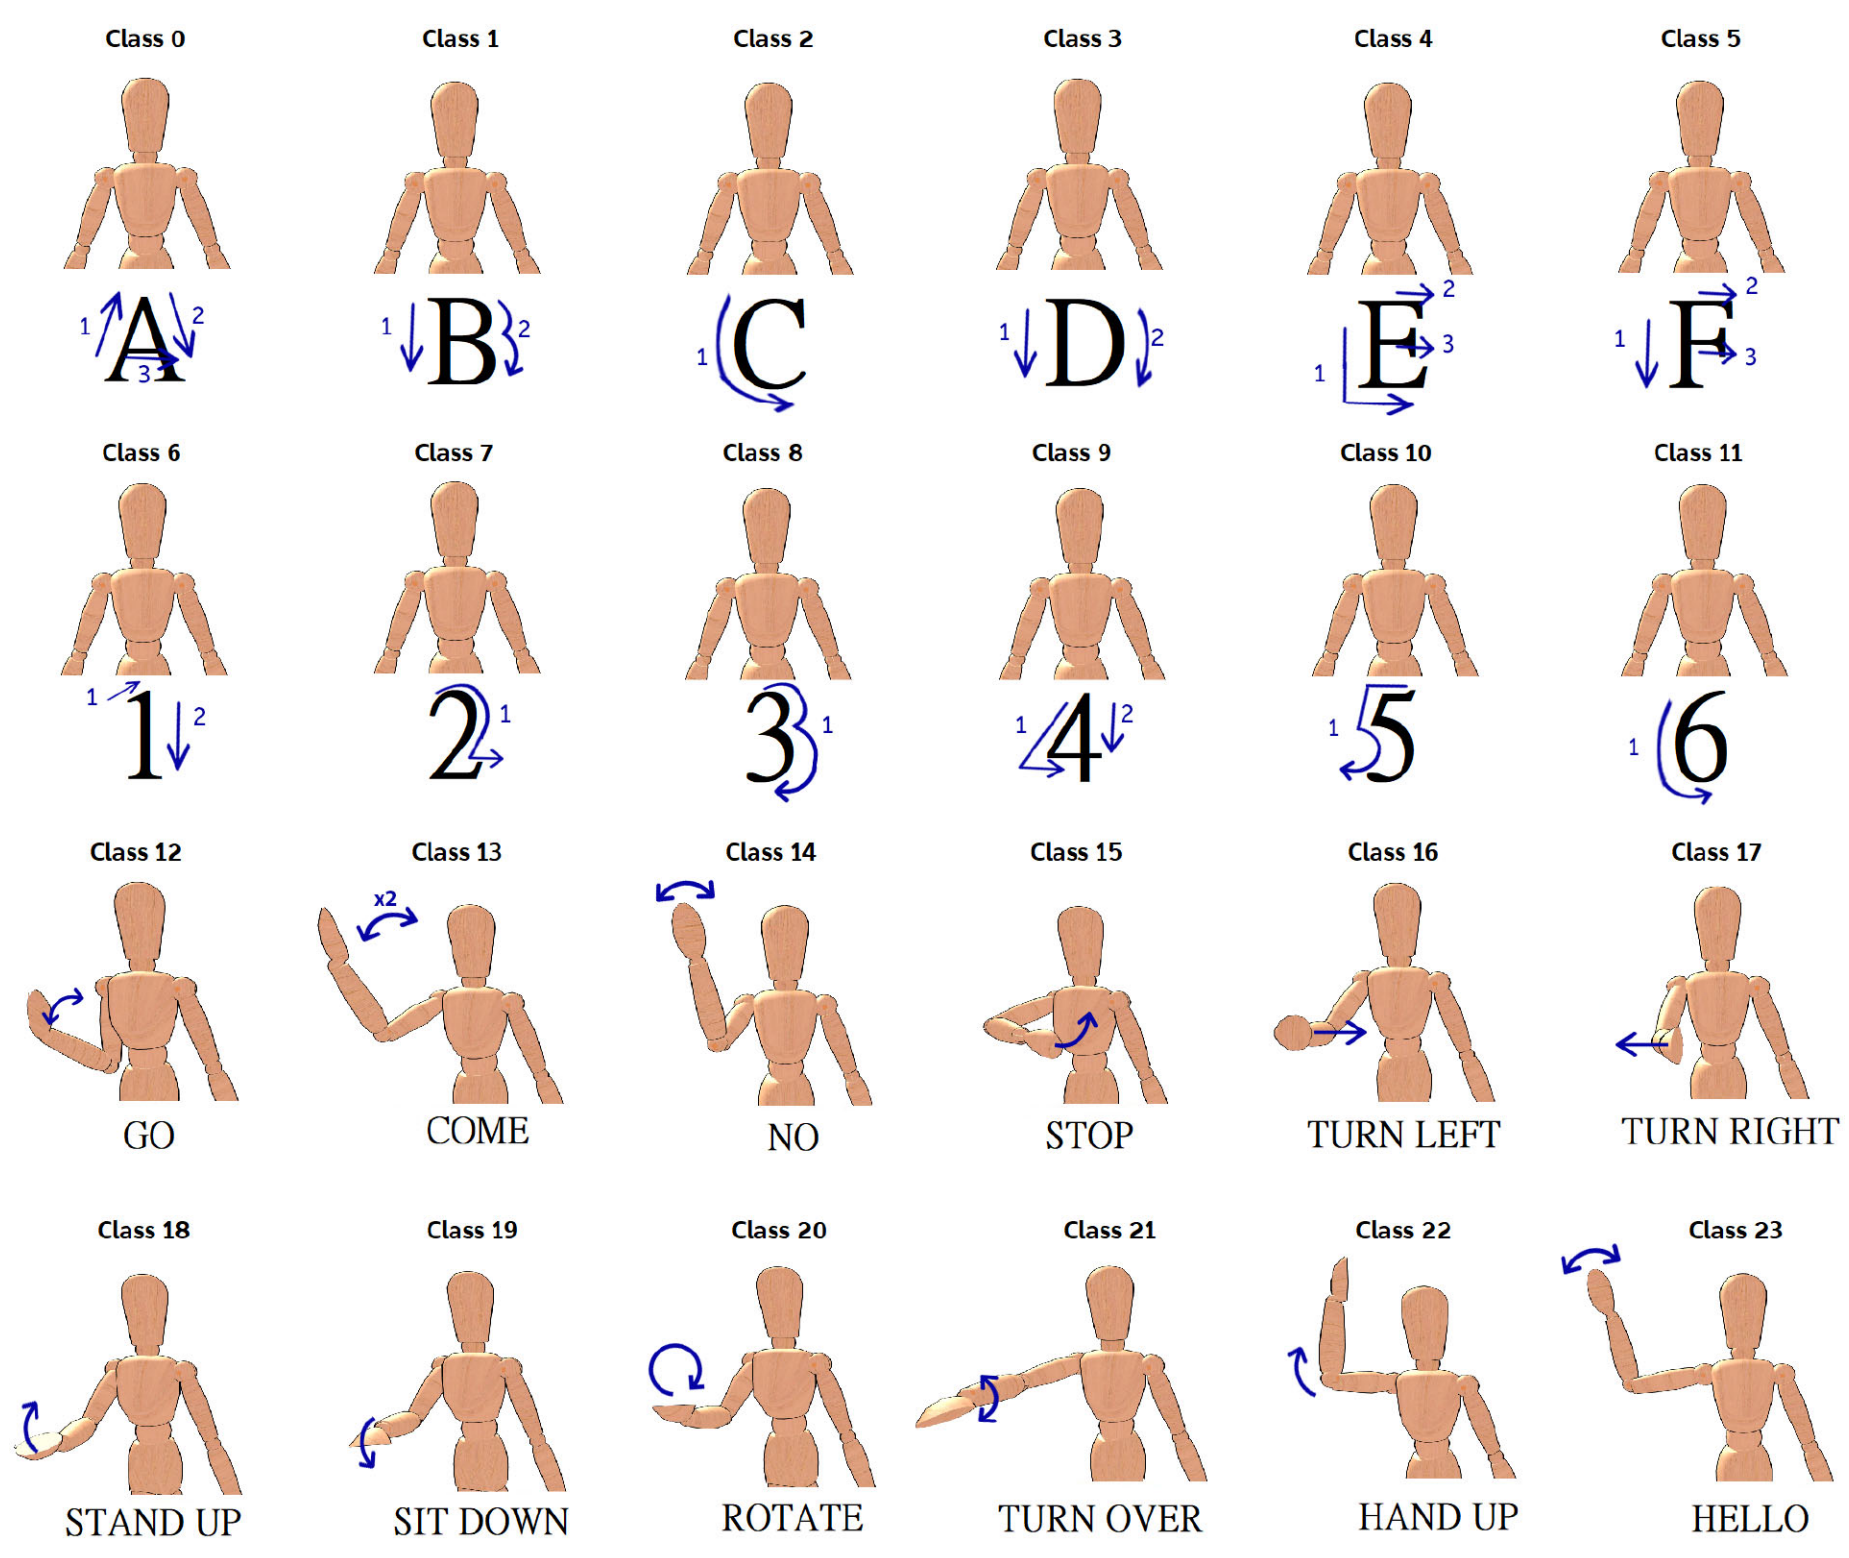


## Important imports

In [2]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from mpl_toolkits import mplot3d
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import LeaveOneGroupOut

## Helper functions

In [3]:
def precision(label, confusion_matrix):
    col = confusion_matrix[:, label]
    if(col.any() == 0):
        conf_matrix = 0
    else:
        conf_matrix = confusion_matrix[label, label] / col.sum()
    return conf_matrix

def recall(label, confusion_matrix):
    row = confusion_matrix[label, :]
    return confusion_matrix[label, label] / row.sum()

def precision_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_precisions = 0
    for label in range(rows):
        sum_of_precisions += precision(label, confusion_matrix)
    return sum_of_precisions / rows

def recall_macro_average(confusion_matrix):
    rows, columns = confusion_matrix.shape
    sum_of_recalls = 0
    for label in range(columns):
        sum_of_recalls += recall(label, confusion_matrix)
    return sum_of_recalls / columns

## 1 - Prepare the dataset class for sample loading

In [4]:
dataset = pd.read_csv("datasets/database_gesture.csv")
dataset.head()

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,Class,Gesture,User
0,0.698043,0.599521,0.589581,0.501449,0.442252,0.569464,0,1,0
1,0.701003,0.597485,0.574135,0.506741,0.444462,0.570066,0,1,0
2,0.708474,0.596326,0.563054,0.510693,0.445220,0.571437,0,1,0
3,0.712697,0.596872,0.559204,0.511894,0.445009,0.572309,0,1,0
4,0.717743,0.598103,0.559908,0.510884,0.444017,0.574870,0,1,0


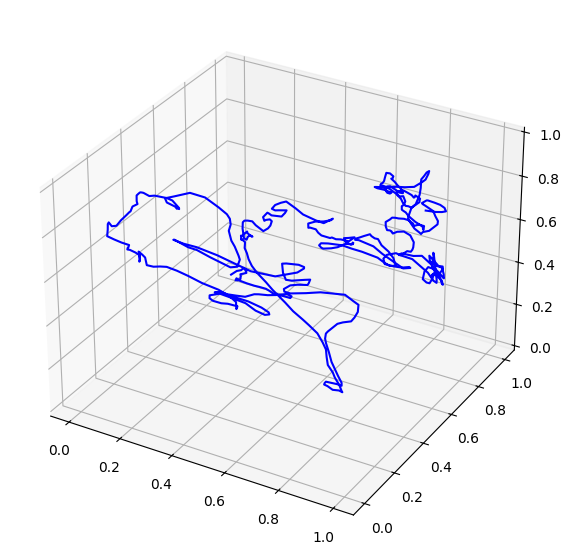

In [5]:
subset = dataset[(dataset['Class']==10) & (dataset['Gesture']==2) & (dataset['User']==0)]

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

# Creating plot
ax.plot3D(subset.iloc[:,1], subset.iloc[:,0], subset.iloc[:,2], color = "blue")

# show plot
plt.show()

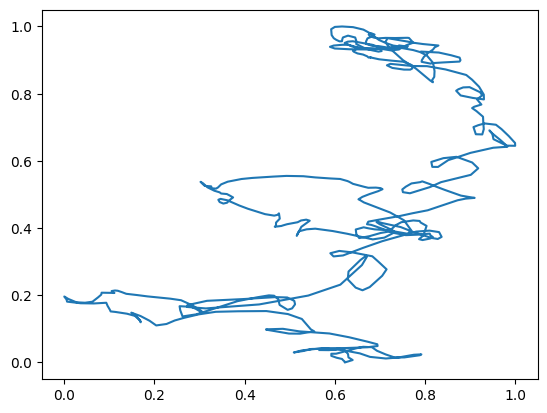

In [6]:
plt.plot(subset.iloc[:,1], subset.iloc[:,0])

In [21]:
import pdb

class IMUDataset(torch.utils.data.Dataset):
    def __init__(self, df, subject_list):
        self.data = torch.tensor(df[df['User'].isin(subject_list)].values, dtype=torch.float32).split(500) # get data from the subjects in the list
        
    def __getitem__(self, idx):
        # pdb.set_trace()
        x = self.data[idx][:,:6] # get the first 6 columns of the data
        y = self.data[idx][:,6].long() # get the last column of the data
        return self.data[idx]

In [20]:
ds = IMUDataset(dataset, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

ds[0].shape, ds[0]

(torch.Size([500, 9]),
 tensor([[0.6980, 0.5995, 0.5896,  ..., 0.0000, 1.0000, 0.0000],
         [0.7010, 0.5975, 0.5741,  ..., 0.0000, 1.0000, 0.0000],
         [0.7085, 0.5963, 0.5631,  ..., 0.0000, 1.0000, 0.0000],
         ...,
         [0.4941, 0.5348, 0.5871,  ..., 0.0000, 1.0000, 0.0000],
         [0.5029, 0.5588, 0.5942,  ..., 0.0000, 1.0000, 0.0000],
         [0.5114, 0.5691, 0.5953,  ..., 0.0000, 1.0000, 0.0000]]))

## 2 - Model definition

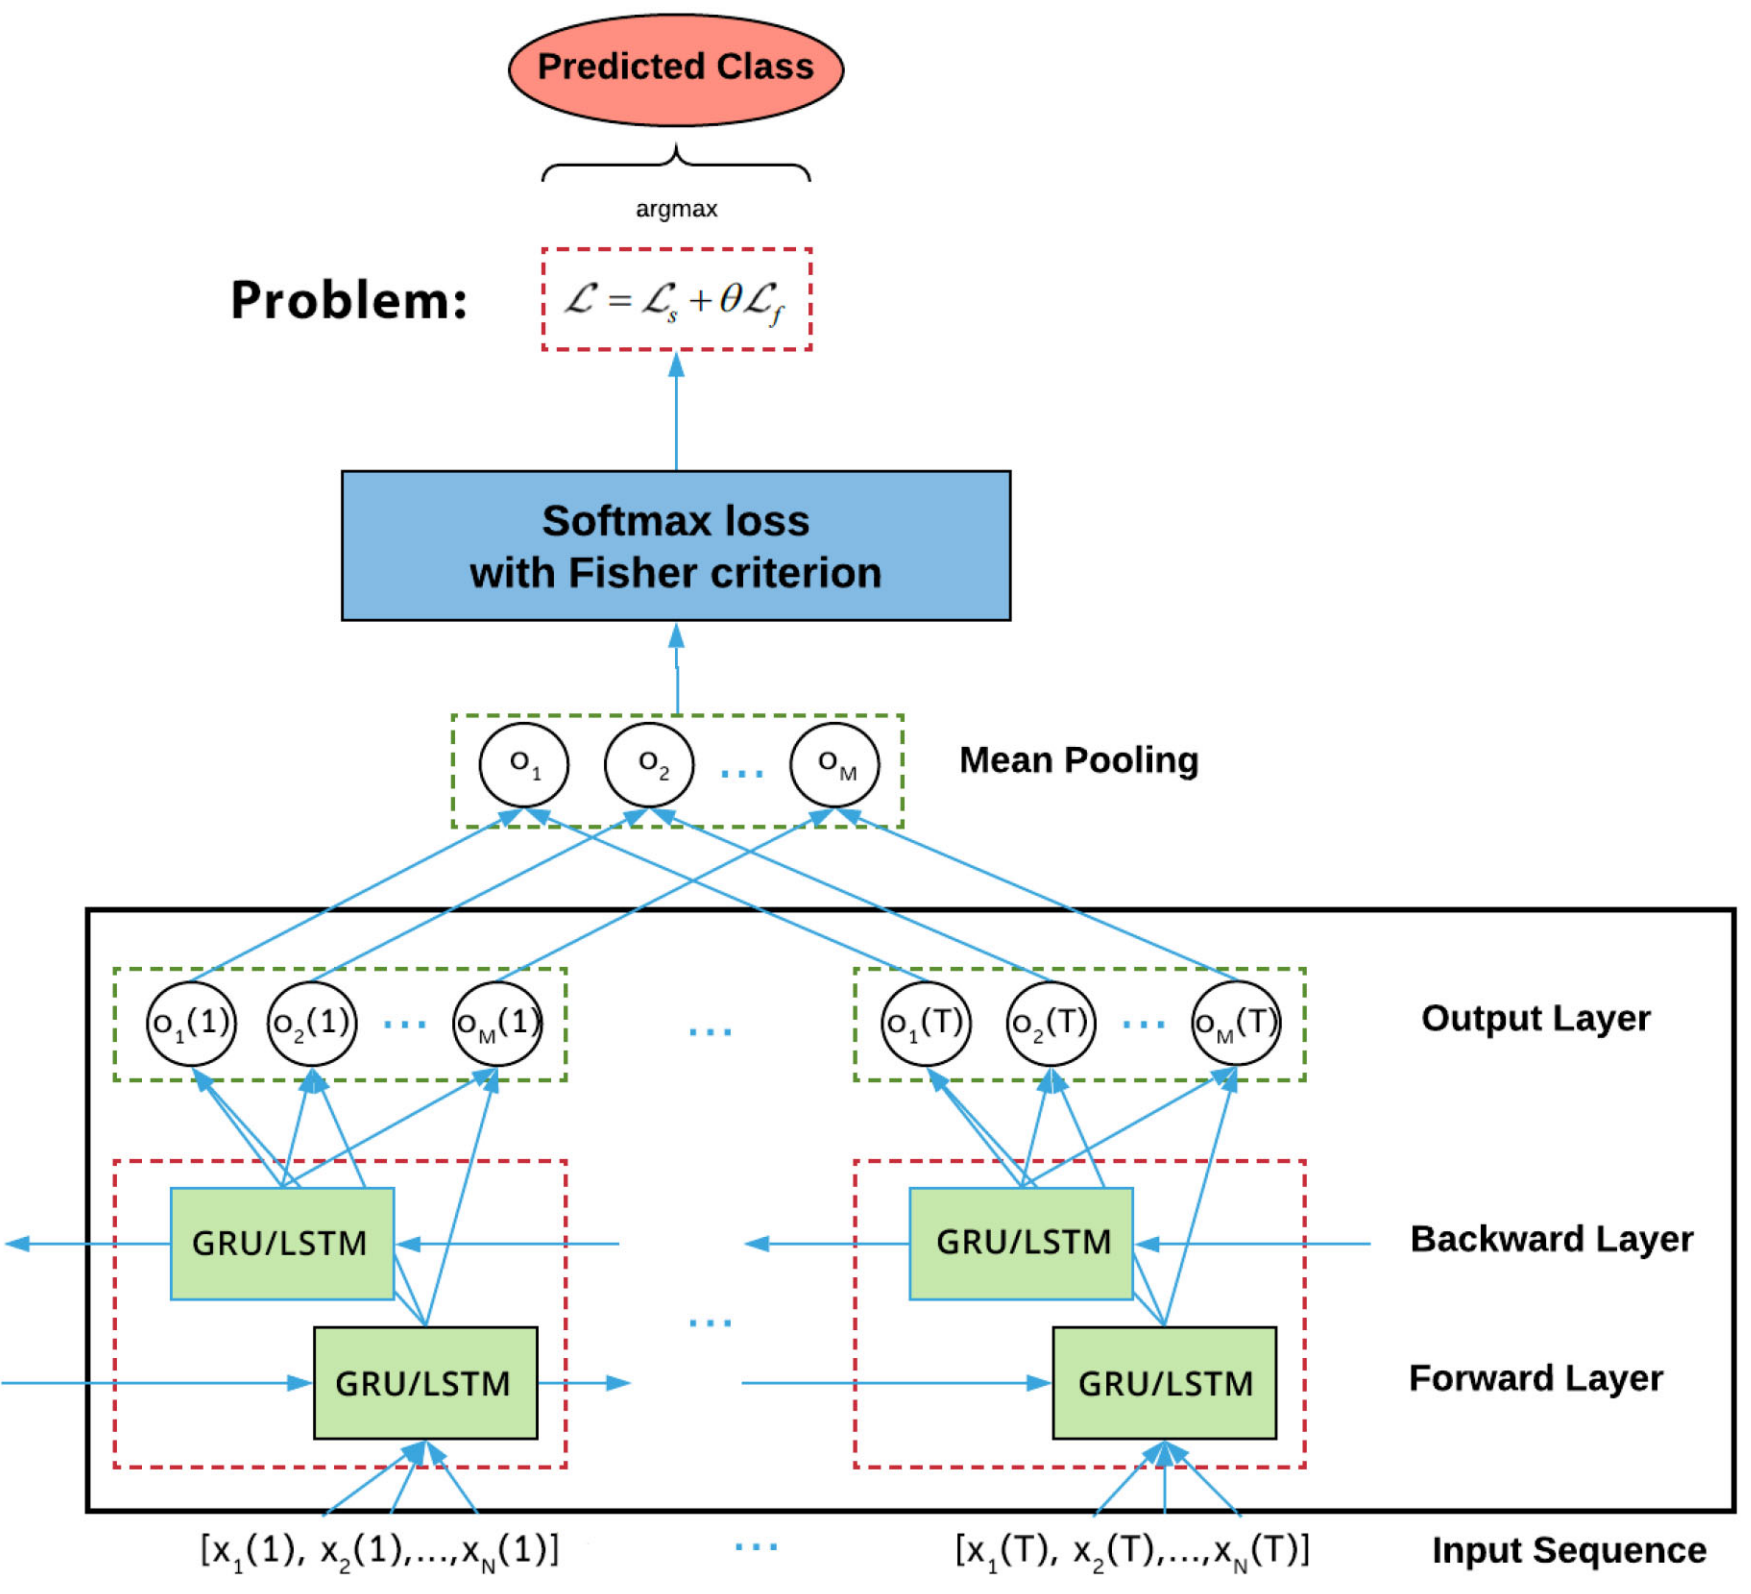

1. Input is first mapped into a 64-dimensional series
2. A bidirectional Gated Recurrent Unit (GRU) with 2 cells models temporal relationships among IMU acquisitions for each sample (torch.nn.GRU)
3. Temporal average pooling is applied to each GRU output

The classifier should provide 25 outputs, namely 12 symbols + 12 gestures + 1 no-actions

In [ ]:
class Model(nn.Module):
    def __init__(self, input_size = 6, output_size = 25): # 6 input features coming from 3 gyroscopes and 3 accelerometers, 25 output classes
        super(Model, self).__init__()
        self.fc = nn.Linear(input_size, 64)
        self.gru = nn.GRU(64, 64, num_layers=2, batch_first=True, bidirectional=True) # 2 layers of bidirectional GRU
        self.relu = nn.ReLU()
        self.classifier = nn.Linear(128, output_size)
        
    def forward(self, x):
        x = self.fc(x)
        x = self.relu(x)
        x, _ = self.gru(x) # the _ is the hidden state, we don't need it
        x = x.mean(dim=1) # average over the temporal dimension

        return self.classifier(x), x # return the logits and the hidden state, needed for the fisher loss

In [28]:
model = Model()
model(torch.randn(3, 500, 6)) # test the model with a random input, 3 samples of 500 timesteps with 6 features

(tensor([[ 0.0105, -0.0821,  0.0521,  0.2163, -0.0838, -0.0690, -0.2262, -0.0911,
           0.0676, -0.0593,  0.0273,  0.0808,  0.0226, -0.0348,  0.0303, -0.1293,
           0.0157, -0.0518,  0.0240, -0.0617, -0.0379,  0.0956, -0.2137,  0.0244,
           0.1569],
         [ 0.0165, -0.0841,  0.0455,  0.2200, -0.0804, -0.0656, -0.2249, -0.0861,
           0.0749, -0.0571,  0.0199,  0.0836,  0.0220, -0.0350,  0.0282, -0.1293,
           0.0197, -0.0543,  0.0238, -0.0625, -0.0431,  0.0995, -0.2086,  0.0322,
           0.1513],
         [ 0.0158, -0.0769,  0.0458,  0.2209, -0.0806, -0.0735, -0.2276, -0.0917,
           0.0746, -0.0600,  0.0258,  0.0789,  0.0222, -0.0260,  0.0299, -0.1303,
           0.0166, -0.0535,  0.0207, -0.0678, -0.0403,  0.0967, -0.2061,  0.0296,
           0.1478]], grad_fn=<AddmmBackward0>),
 tensor([[-0.0148,  0.0121, -0.1448,  0.0720, -0.3307,  0.0299, -0.0289,  0.0167,
           0.1509, -0.0342, -0.2247,  0.0569, -0.0067,  0.0961,  0.0493,  0.0157,
          

## 3 - Implement the loss function

The total loss function used to optimize the neural model is a combination of the Fisher criterion with the cross entropy loss the following:
$\mathcal{L} = \mathcal{L}_s + \theta\mathcal{L}_f$.

The Fisher criterion is computed per batch of size $m$, where $\mu_{y_i}$ is the $i^{th}$  class mean of output vectors, $\delta$ is the discriminative factor, and $O_i$ is the output vector produced by the model while $n$ is the number of classes $$\mathcal{L}_f = \frac{1}{m}\sum^m_{i=1}{\lVert O_i - \mu_{y_i}}\rVert^2_2 - \frac{\delta}{n(n-1)}\sum^n_{j=1,k=1}\lVert\mu_j-\mu_k\rVert^2_2$$.

The PyTorch implementation of the cross entropy criterion might be used.

The discriminative factor of the Fisher criterion $\delta$ is set to 0.01, while the scalar $\alpha$ used for its linear combination with the cross entropy loss is set to 0.1.


In [172]:
# the mu is a moving average of the mean and the variance of the gradients, we can't have a ground truth for it, so we need to calculate it

import torch
import torch.nn as nn

class FisherLoss(nn.Module):
    def __init__(self, alpha = 0.1, delta = 0.01, device = 'cuda'):
        super(FisherLoss, self).__init__()
        self.alpha = alpha
        self.delta = delta
        self.mu = torch.randn(25, 128, requires_grad=False).to(device) # initialize the mu with random values
        
    def forward(self, output, target):
        loss1 = 0.0
        for o, t in zip(output, target):
            loss1 += torch.pow(o - self.mu[t], 2).mean() # calculate the loss for each sample, mean over the batch
        loss1 /= output.size(0) # average over the batch
        
        loss2 = 0.0
        for i in range(25):
            for j in range(i+1, 25):
                # calculate the loss for each pair of classes, it's a triangular matrix, so we don't need to calculate the diagonal and the lower part
                loss2 += nn.functional.mse_loss(self.mu[i], self.mu[j]) # update the mu with the mean squared error
        
        loss2 = loss2 / (25 * 24) # average over the number of pairs
        
        # now update the mu with the moving average, centroids of the classes
        with torch.no_grad():
            for o, t in zip(output, target):
                self.mu[t] = (1 - self.alpha) * self.mu[t] + self.alpha * o # update the mu with the moving average
            
        return loss1 - self.delta * loss2
            

In [ ]:
class CompoundedLoss(nn.Module):
    def __init__(self, alpha = 0.9, delta = 0.01, theta = 0.1, device = 'cuda'):
        super(CompoundedLoss, self).__init__()
        self.fisher = FisherLoss(alpha, delta, device)
        self.ce = nn.CrossEntropyLoss()
        self.theta = theta
        
    def forward(self, output, logits, target):
        return self.ce(logits, target) + self.theta * self.fisher(output, target) # compound the losses, cross entropy needs the logits, fisher needs the hidden states

In [197]:
# Corrected dimensions for a batch of 32 samples
features = torch.randn(32, 128)  # 32 samples, 128 feature dimensions
labels = torch.randint(0, 24, (32,))  # 32 labels, ranging 0-24

loss = FisherLoss(alpha=0.9, delta=0.01, device='cpu')
loss_value = loss(features, labels)

loss_value

tensor(2.0436)

4 - Leave-One-Subject-Out training procedure

In [ ]:
# LOSO
acc_scores = []
precision_scores = []
recall_scores = []
f1_scores = []
print("SPLIT -----------------------------")
subject = subject(user_data)
print(subject)
logo = LeaveOneGroupOut()
logo.get_n_splits(X_data, y_data, subject)
logo.get_n_splits(groups=subject)  # 'subject' is always required
print(logo)


for train_index, test_index in logo.split(X_data, y_data, subject):
    #remove comment on print to see the index division
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X_data[train_index], X_data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]

    #shuffle train
    X_train, y_train = shuffle(X_train, y_train, random_state = 0)
    # lo shuffle del test è ridondante in questo caso
    #X_test, y_test = shuffle(X_test, y_test)
    #print(y_test)

    print("dimension of train, test, and label")
    print(X_train.shape)
    print(X_test.shape)
    print(y_train.shape)
    print(y_test.shape)

    user_count = str(user_data[test_index][0]).lstrip('[').rstrip(']')
    print("USER SPLIT n° %s xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx" %user_count)
    #FIT MODEL
    accuracy_model, precision_model, recall_model, f1_model = fit_model(X_train, X_test, y_train, y_test)
    #Save Accuracy
    acc_scores.append(accuracy_model)
    #Save Precision
    precision_scores.append(precision_model)
    #Save Recall
    recall_scores.append(recall_model)
    #Save F1-measure
    f1_scores.append(f1_model)
    #MEAN Accuracy
    mean_accuracy = np.mean(acc_scores)
    #STDEV Accuracy
    stdev_accuracy = np.std(acc_scores)
    
#MEAN Precision - Recall - F1-measure
mean_precision = np.mean(precision_scores)
mean_recall = np.mean(recall_scores)
mean_f1 = np.mean(f1_scores)
print("--------------------------------------------------------------")
print("precision CV: {}\n".format(mean_precision)+\
        "recall CV: {}\n".format(mean_recall)+\
        "F1 CV: {}\n".format(mean_f1)+\
        "accuracy CV: {}\n".format(mean_accuracy)+\
        "accuracy stdev CV: {}".format(stdev_accuracy))

#Save result in txt file
nresult = 1
with open("result/validation_LOSO_FBGRU_%s.txt" %nresult, "w") as txt_file:
    txt_file.write("precision CV: {}\n".format(mean_precision)+\
        "recall CV: {}\n".format(mean_recall)+\
        "F1 CV: {}\n".format(mean_f1)+\
        "accuracy CV: {}\n".format(mean_accuracy)+\
        "accuracy stdev CV: {}".format(stdev_accuracy))

SPLIT -----------------------------


NameError: name 'subject' is not defined